## Imports

In [59]:
import pandas as pd
import re, unidecode, sqlalchemy as sa
from sqlalchemy.orm import Session
from sqlalchemy.dialects.postgresql import insert
from tqdm.auto import tqdm
from typing import Dict, List, Tuple, Any

from apps.ingestion.seed_and_ingest import Player, FootballNews, Base, get_engine

DB_URL = "postgresql+psycopg2://scout:scout@db:5432/scouting"
engine = sa.create_engine(DB_URL)

## Players Table

In [3]:
# total de jugadores
with engine.connect() as conn:
    n_players = conn.scalar(sa.text("SELECT COUNT(*) FROM players"))
print(f"Hay {n_players:,} jugadores")

Hay 18,590 jugadores


In [4]:
df_players = pd.read_sql_table("players", con=engine)

In [ ]:
df_players[df_players["full_name"].str.contains("Cardoso")]

In [ ]:
df_players.columns

In [ ]:
df_players.info()

## Creating feature_vector Column

In [ ]:
from sqlalchemy import create_engine, text

# 1️⃣  Conexión -------------------------------------------------
engine = create_engine(
    "postgresql+psycopg2://scout:scout@db:5432/scouting",
    isolation_level="AUTOCOMMIT",  # evita tener que hacer COMMIT explícito
)

# 2️⃣  Parámetros que necesitas saber de antemano --------------
PLAYER_DIM = 43   # ← dimensión real de tu vector de jugador
LISTS      = 140   # ← granularidad del índice IVFFLAT

with engine.begin() as conn:
    # 3️⃣  Activa la extensión pgvector (idempotente) -----------
    conn.execute(text("CREATE EXTENSION IF NOT EXISTS vector;"))

    # 4️⃣  Añade la nueva columna vector(N) y migra los datos ---
    conn.execute(text(f"""
        ALTER TABLE players
          ADD COLUMN IF NOT EXISTS feature_tmp vector({PLAYER_DIM});

        UPDATE players
          SET feature_tmp = feature_vector::vector
          WHERE feature_tmp IS NULL;      -- evita tocar filas ya convertidas

        ALTER TABLE players
          DROP COLUMN IF EXISTS feature_vector;
        ALTER TABLE players
          RENAME COLUMN feature_tmp TO feature_vector;
    """))

    # 5️⃣  Crea (o recrea) el índice IVFFLAT --------------------
    conn.execute(text(f"""
        CREATE INDEX IF NOT EXISTS players_feature_vec_idx
        ON players USING ivfflat (feature_vector vector_cosine_ops)
        WITH (lists = {LISTS});
    """))

print("Migración a pgvector finalizada ✔️")

### Populate feature_vector Column

In [ ]:
FEATURE_COLS = [
    "minutes", "minutes_90s",
    "goals", "assists",
    "expected_goals", "expected_assists",
    "no_penalty_expected_goals_plus_expected_assists",
    "progressive_carries", "progressive_passes", "progressive_passes_received",
    "goals_per90", "assists_per90", "goals_assists_per90",
    "expected_goals_per90", "expected_assists_per90", "expected_goals_assists_per90",
    "gk_goals_against", "gk_pens_allowed", "gk_free_kick_goals_against",
    "gk_corner_kick_goals_against", "gk_own_goals_against",
    "gk_psxg", "gk_psnpxg_per_shot_on_target_against",
    "passes_completed", "passes", "passes_pct",
    "passes_progressive_distance", "passes_completed_long", "passes_long", "passes_pct_long",
    "tackles", "tackles_won", "challenge_tackles", "challenges",
    "challenge_tackles_pct", "challenges_lost",
    "blocks", "blocked_shots", "blocked_passes",
    "interceptions", "tackles_interceptions", "clearances", "errors"
]

df = pd.read_sql(
    f"SELECT id, {', '.join(FEATURE_COLS)} FROM players",
    engine
)

In [ ]:
df

#### Standarization feature_vector values

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
emb_matrix = scaler.fit_transform(df[FEATURE_COLS]).astype("float32")

In [ ]:
df["feature_vector"] = [vec.tolist() for vec in emb_matrix]

In [ ]:
df.info()

In [ ]:
from pgvector.sqlalchemy import Vector

with engine.begin() as conn:
    conn.execute(
        text("""
            UPDATE players
            SET feature_vector = :vec
            WHERE id = :pid
        """),
        [{"pid": pid, "vec": vec} for pid, vec in zip(df.id, df.feature_vector)]
    )

#### Checks

In [ ]:
check = pd.read_sql(
    "SELECT vector_dims(feature_vector) AS dim, COUNT(*) FROM players GROUP BY dim;",
    engine
)
assert check["dim"].iloc[0] == 43, "Alguna fila no tiene dimensión 43"
print(check)

In [ ]:
with engine.begin() as conn:
    conn.execute(text("ANALYZE players;"))
    conn.execute(text("SET ivfflat.probes = 10;")) 

In [ ]:
query = """
EXPLAIN (ANALYZE, BUFFERS)
SELECT * FROM players
ORDER BY feature_vector <=> (SELECT feature_vector FROM players WHERE id = 42)
LIMIT 15;
"""

In [ ]:
with engine.begin() as conn:
    conn.execute(text(query))

In [ ]:
df_plan = pd.read_sql(query, engine)
display(df_plan)

In [ ]:
df

## Football news Table validations 

In [ ]:
# primeras 5 noticias
query = """
SELECT *
FROM football_news
ORDER BY published_at DESC
LIMIT 5
"""
df = pd.read_sql(query, con=engine)
df

In [ ]:
df.summary[4]

## Player Id - News ID table creation

In [ ]:
from sqlalchemy import create_engine, text

# 1️⃣  Conexión -------------------------------------------------
engine = create_engine(
    "postgresql+psycopg2://scout:scout@db:5432/scouting",
    isolation_level="AUTOCOMMIT",  # evita tener que hacer COMMIT explícito
)

In [ ]:
query = """
CREATE TABLE IF NOT EXISTS player_news (
  player_id  INTEGER NOT NULL REFERENCES players(id) ON DELETE CASCADE,
  news_id    INTEGER NOT NULL REFERENCES football_news(id) ON DELETE CASCADE,
  PRIMARY KEY (player_id, news_id)
);
"""

query2 = """
CREATE INDEX IF NOT EXISTS player_news_player_idx
ON player_news(player_id);
"""

In [ ]:
with engine.begin() as conn:
    conn.execute(text(query))

    conn.execute(text(query2))

print("Tabla Creada finalizada ✔️")

In [ ]:
player_news = sa.Table(
    "player_news", Base.metadata,
    sa.Column("player_id", sa.Integer, primary_key=True),
    sa.Column("news_id",   sa.Integer, primary_key=True),
    extend_existing=True
)

In [ ]:
def normalize(text: str) -> str:
    """minúsculas y sin tildes/acentos para comparar."""
    return unidecode.unidecode(text).lower().strip()

with Session(engine) as sess:
    # ── 1. Diccionario {nombre normalizado: id} ────────────────────────
    players = sess.query(Player.id, Player.full_name).all()
    name_to_id = {normalize(p.full_name): p.id for p in players}

    # regex con todos los nombres (palabra completa)
    pattern = r"\b(" + "|".join(re.escape(n) for n in name_to_id) + r")\b"
    name_re = re.compile(pattern, re.I)

    # ── 2. Iteramos con barra de progreso sobre las noticias ───────────
    news_rows = sess.query(FootballNews).all()
    inserted = 0

    for news in tqdm(news_rows, desc="Vinculando noticias", unit="noticia"):
        # nombres encontrados en el artículo
        matches = {normalize(m.group(0)) for m in name_re.finditer(news.article_text)}

        for norm_name in matches:
            player_id = name_to_id.get(norm_name)
            if not player_id:
                continue  # nombre no está en la tabla players

            stmt = (
                insert(player_news)
                .values(player_id=player_id, news_id=news.id)
                .on_conflict_do_nothing()
            )
            sess.execute(stmt)
            inserted += 1

    sess.commit()

print(f"🔗 player_news enlazados: {inserted}")


In [ ]:
# Conteo global
with engine.connect() as conn:
    n_players_news = conn.scalar(sa.text("SELECT COUNT(*) FROM player_news"))

In [ ]:
print(f"Hay {n_players_news:,} jugadores con noticas asociadas")

In [ ]:
# Top-10 jugadores con más artículos
top = pd.read_sql("""
    SELECT p.full_name, COUNT(*) AS n_news
    FROM player_news pn
    JOIN players p ON p.id = pn.player_id
    GROUP BY p.full_name
    ORDER BY n_news DESC
    LIMIT 10
""", engine)
display(top)

# Últimas 5 noticias para Rodri
rodri_news = pd.read_sql("""
    SELECT n.title, n.summary, n.published_at
    FROM player_news pn
    JOIN football_news n ON n.id = pn.news_id
    WHERE pn.player_id = 842
    ORDER BY n.published_at DESC
    LIMIT 5
""", engine)
display(rodri_news)

## Testing Radar and pizza charts

In [33]:
from mplsoccer import PyPizza, Radar, FontManager, grid
import numpy as np

In [34]:
URL1 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-Regular.ttf')
serif_regular = FontManager(URL1)
URL2 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-ExtraLight.ttf')
serif_extra_light = FontManager(URL2)
URL3 = ('https://raw.githubusercontent.com/google/fonts/main/ofl/rubikmonoone/'
        'RubikMonoOne-Regular.ttf')
rubik_regular = FontManager(URL3)
URL4 = 'https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Thin.ttf'
robotto_thin = FontManager(URL4)
URL5 = ('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
        'RobotoSlab%5Bwght%5D.ttf')
robotto_bold = FontManager(URL5)

In [180]:
row = df_players.loc[df_players["full_name"] == "Federico Valverde"].iloc[0]  # ejemplo

In [181]:
row

id                                                                                                40
full_name                                                                          Federico Valverde
age                                                                                               26
nationality                                                                                      URU
position                                                                                          MF
club                                                                                     Real Madrid
team_logo                                          https://cdn.ssref.net/req/202507021/tlogo/fb/5...
league                                                                                       La Liga
minutes                                                                                         3032
minutes_90s                                                                                

In [182]:
# ────────────────────────────────────────────────────────────────────────────
# Colour palette (light tones)
# ────────────────────────────────────────────────────────────────────────────
ATT_CLR = "#8ED18E"   # light green  – attacking
POS_CLR = "#9CCAF9"   # light blue   – possession
DEF_CLR = "#F9B97C"   # light orange – defending
COLORS = {"att": ATT_CLR, "pos": POS_CLR, "def": DEF_CLR}
TEXT_CLR = "#000000"

# ────────────────────────────────────────────────────────────────────────────
# Metric definitions
# ────────────────────────────────────────────────────────────────────────────
RADAR_METRICS: List[Tuple[str, str, Any | None]] = [
    ("Edad", "age", 45),
    ("Min/juego", None, 100),          # minutes ÷ 90s
    ("Partidos_90s", "minutes_90s", 50),
    ("Goles", "goals", 50),
    ("Asist", "assists", 20),
    ("G+A", None, 50),
]

# label, df‑column, category
ROLE_METRICS = {
    'GK': [
          ['PSxG_ev', 'gk_psxg', 'def', 73.5],
          ['GA', 'gk_goals_against', 'def', 77.0],
          ['Pens', 'gk_pens_allowed', 'def', 13.0],
          ['GA_FK', 'gk_free_kick_goals_against', 'def', 3.0],
          ['GA_CK', 'gk_corner_kick_goals_against', 'def', 11.0],
          ['OwnGA', 'gk_own_goals_against', 'def', 5.0],
          ['ProgDist', 'passes_progressive_distance', 'pos', 28154.0],
          ['%Pass', 'passes_pct', 'pos', 100.0],
          ['LongCmp', 'passes_completed_long', 'pos', 462.0]
    ],
     'DF': [
          ['Interc', 'interceptions', 'def', 72.0],
          ['Tackles', 'tackles', 'def', 151.0],
          ['Tk_Won', 'tackles_won', 'def', 99.0],
          ['BlkShot', 'blocked_shots', 'def', 57.0],
          ['Clear', 'clearances', 'def', 352.0],
          ['Duel%', 'challenge_tackles_pct', 'def', 100.0],
          ['ProgDist', 'passes_progressive_distance', 'pos', 28154.0],
          ['%Pass', 'passes_pct', 'pos', 100.0],
          ['LongCmp', 'passes_completed_long', 'pos', 462.0]
     ],
     'MF': [
          ['xA/90', 'expected_assists_per90', 'att', 2.0],
          ['G+A/90', 'goals_assists_per90', 'att', 3.0],
          ['xG/90', 'expected_goals_per90', 'att', 1.5],
          ['ProgCarr', 'progressive_carries', 'pos', 213.0],
          ['ProgDist', 'passes_progressive_distance', 'pos', 28154.0],
          ['%Pass', 'passes_pct', 'pos', 100.0],
          ['Interc', 'interceptions', 'def', 72.0],
          ['Tk+Int', 'tackles_interceptions', 'def', 207.0],
          ['Blocks', 'blocks', 'def', 77.0]
     ],
     'FW': [
          ['G/90', 'goals_per90', 'att', 1.5],
          ['xG/90', 'expected_goals_per90', 'att', 1.5],
          ['A/90', 'assists_per90', 'att', 2.0],
          ['G+A/90', 'goals_assists_per90', 'att', 3.0],
          ['xGA/90', 'expected_goals_assists_per90', 'att', 3.0],
          ['ProgRec', 'progressive_passes_received', 'pos', 488.0],
          ['ProgPass', 'progressive_passes', 'pos', 440.0],
          ['ProgCarr', 'progressive_carries', 'pos', 213.0],
          ['%Pass', 'passes_pct', 'pos', 100.0]
    ]
}

INVERSE = {
    "gk_goals_against", "gk_free_kick_goals_against",
    "gk_corner_kick_goals_against", "gk_own_goals_against",
}

In [183]:
stats = row.to_dict()

### Radar Chart

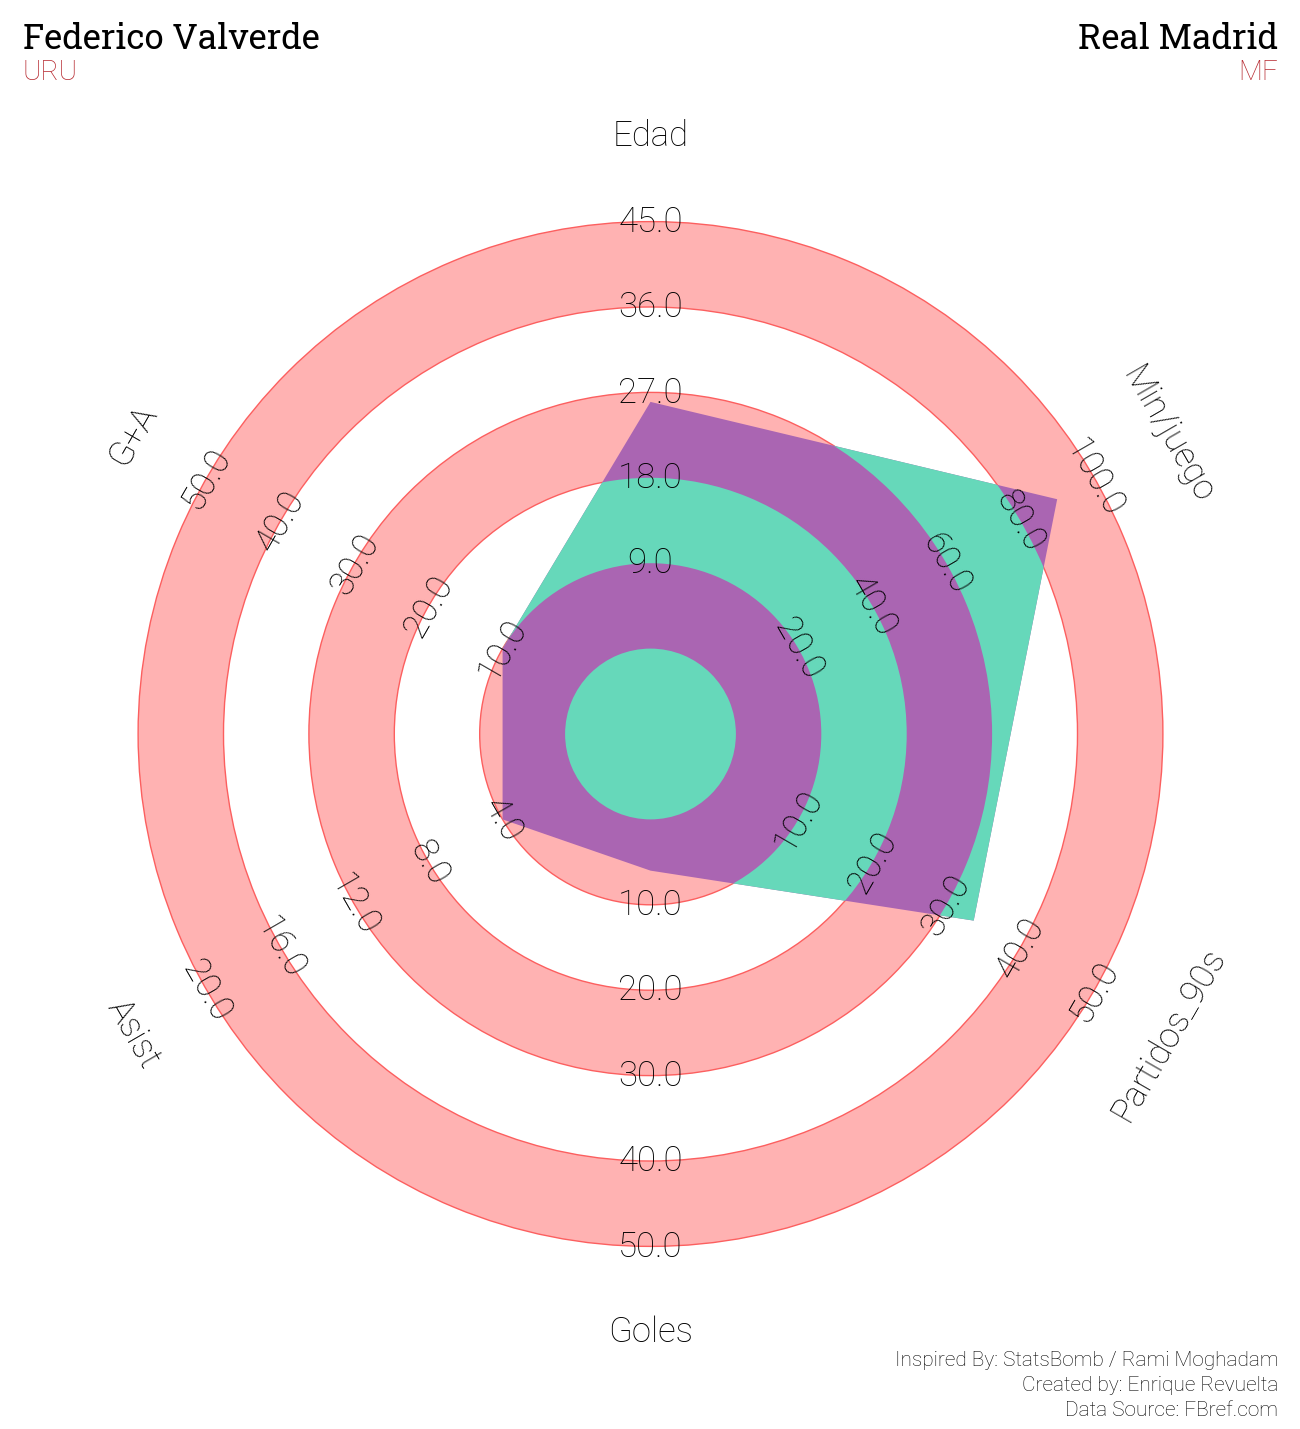

In [184]:
labels, vals, max_vals = [], [], []
for label, col, max_val in RADAR_METRICS:
    if col is None and label == "G+A":
        v = stats.get("goals", 0) + stats.get("assists", 0)
    elif col is None:  # minutes per game
        games = stats.get("minutes_90s", 1) or 1
        v = stats.get("minutes", 0) / games
    else:
        v = stats.get(col, 0)
    labels.append(label)
    vals.append(float(v))
    max_vals.append(max_val)

vals_arr = np.array(vals, dtype=float)
low = np.zeros_like(vals_arr)
high = max_vals

params = [s[0] for s in RADAR_METRICS]

lower_is_better = ['Miscontrol']

radar = Radar(params, low, high,
              lower_is_better=lower_is_better,
              round_int=[False]*len(params),
              num_rings=5, 
              ring_width=1, center_circle_radius=1)

# creating the figure using the grid function from mplsoccer:
fig, axs = grid(figheight=14, grid_height=0.915, title_height=0.06, endnote_height=0.025,
                title_space=0, endnote_space=0, grid_key='radar', axis=False)

# plot the radar
radar.setup_axis(ax=axs['radar'])
rings_inner = radar.draw_circles(ax=axs['radar'], facecolor='#ffb2b2', edgecolor='#fc5f5f')
radar_output = radar.draw_radar(vals_arr, ax=axs['radar'],
                                kwargs_radar={'facecolor': '#aa65b2'},
                                kwargs_rings={'facecolor': '#66d8ba'})
radar_poly, rings_outer, vertices = radar_output
range_labels = radar.draw_range_labels(ax=axs['radar'], fontsize=25,
                                       fontproperties=robotto_thin.prop)
param_labels = radar.draw_param_labels(ax=axs['radar'], fontsize=25,
                                       fontproperties=robotto_thin.prop)
endnote_text = axs['endnote'].text(0.99, 1.4, 'Inspired By: StatsBomb / Rami Moghadam', fontsize=15,
                                   fontproperties=robotto_thin.prop, ha='right', va='center')
endnote_text2 = axs['endnote'].text(0.99, 0.7, 'Created by: Enrique Revuelta', fontsize=15,
                                   fontproperties=robotto_thin.prop, ha='right', va='center')
endnote_text2 = axs['endnote'].text(0.99, 0.0, 'Data Source: FBref.com', fontsize=15,
                                   fontproperties=robotto_thin.prop, ha='right', va='center')
title1_text = axs['title'].text(0.01, 0.65, row["full_name"], fontsize=25,
                                fontproperties=robotto_bold.prop, ha='left', va='center')
title2_text = axs['title'].text(0.01, 0.25, row["nationality"], fontsize=20,
                                fontproperties=robotto_thin.prop,
                                ha='left', va='center', color='#B6282F')
title3_text = axs['title'].text(0.99, 0.65, row["club"], fontsize=25,
                                fontproperties=robotto_bold.prop, ha='right', va='center')
title4_text = axs['title'].text(0.99, 0.25, row["position"], fontsize=20,
                                fontproperties=robotto_thin.prop,
                                ha='right', va='center', color='#B6282F')

### Pizza Chart

In [185]:
import matplotlib.pyplot as plt

In [186]:
font_normal = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Regular.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Italic.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab[wght].ttf')

In [187]:
role = row["position"]

params, values, cats, max_vals = [], [], [], []
for lbl, col, cat, max_val in ROLE_METRICS[role]:
    val = float(stats.get(col, 0.0))
    if col in INVERSE:          # invertir métricas donde menos es mejor
        val = -val
    params.append(lbl)
    values.append(val)
    cats.append(cat)
    max_vals.append(max_val)

slice_colors = [COLORS[c] for c in cats]
text_colors = ["#000000"] * len(cats)
min_vals = [0.0] * len(max_vals)

In [190]:
player = row["full_name"]
team = row["club"]

Text(0.99, 0.02, 'Created by: Enrique Revuelta\nData Source: fbref\nInspired by: @Worville, @FootballSlices, @somazerofc & @Soumyaj15209314')

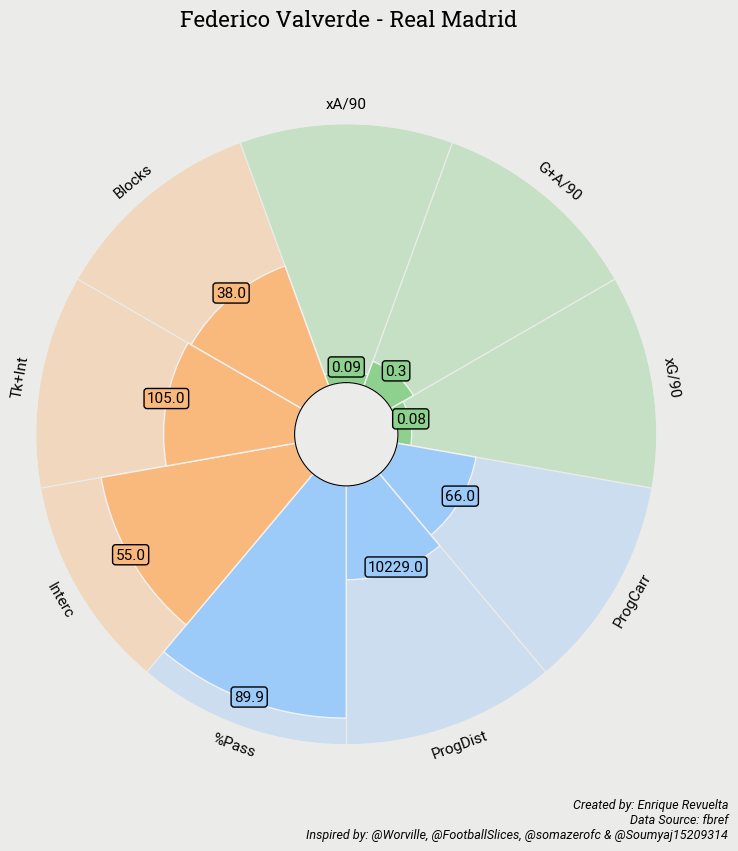

In [192]:
# instantiate PyPizza class
baker = PyPizza(
    params=params,                  # list of parameters
    min_range=min_vals,        # min range values
    max_range=max_vals,        # max range values
    background_color="#EBEBE9",     # background color
    straight_line_color="#EBEBE9",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=0,               # linewidth of last circle
    other_circle_lw=0,              # linewidth for other circles
    inner_circle_size=20            # size of inner circle
)

# plot pizza
fig, ax = baker.make_pizza(
    values,                          # list of values
    figsize=(8, 8.5),                # adjust figsize according to your need
    color_blank_space="same",        # use same color to fill blank space
    slice_colors=slice_colors,       # color for individual slices
    value_colors=text_colors,        # color for the value-text
    value_bck_colors=slice_colors,   # color for the blank spaces
    blank_alpha=0.4,                 # alpha for blank-space colors
    kwargs_slices=dict(
        edgecolor="#F2F2F2", zorder=2, linewidth=1
    ),                               # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=11,
        fontproperties=font_normal.prop, va="center"
    ),                               # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=11,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                                # values to be used when adding parameter-values
)

# add title
fig.text(
    0.515, 0.975, f"{player} - {team}", size=16,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add credits
CREDIT_1 = "Data Source: fbref"
CREDIT_2 = "Inspired by: @Worville, @FootballSlices, @somazerofc & @Soumyaj15209314"
CREDIT_3 = "Created by: Enrique Revuelta"

fig.text(
    0.99, 0.02, f"{CREDIT_3}\n{CREDIT_1}\n{CREDIT_2}", size=9,
    fontproperties=font_italic.prop, color="#000000",
    ha="right"
)

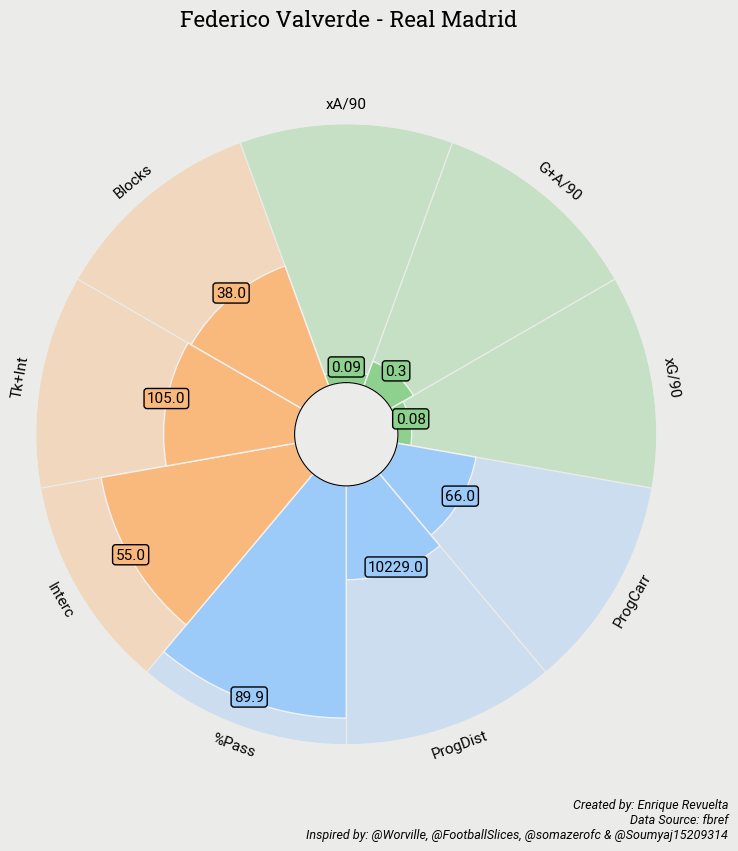

In [193]:
fig

In [194]:
import importlib, apps.agent_service.viz_tools as vt
importlib.reload(vt)

<module 'apps.agent_service.viz_tools' from '/app/apps/agent_service/viz_tools.py'>

In [195]:
row

id                                                                                                40
full_name                                                                          Federico Valverde
age                                                                                               26
nationality                                                                                      URU
position                                                                                          MF
club                                                                                     Real Madrid
team_logo                                          https://cdn.ssref.net/req/202507021/tlogo/fb/5...
league                                                                                       La Liga
minutes                                                                                         3032
minutes_90s                                                                                

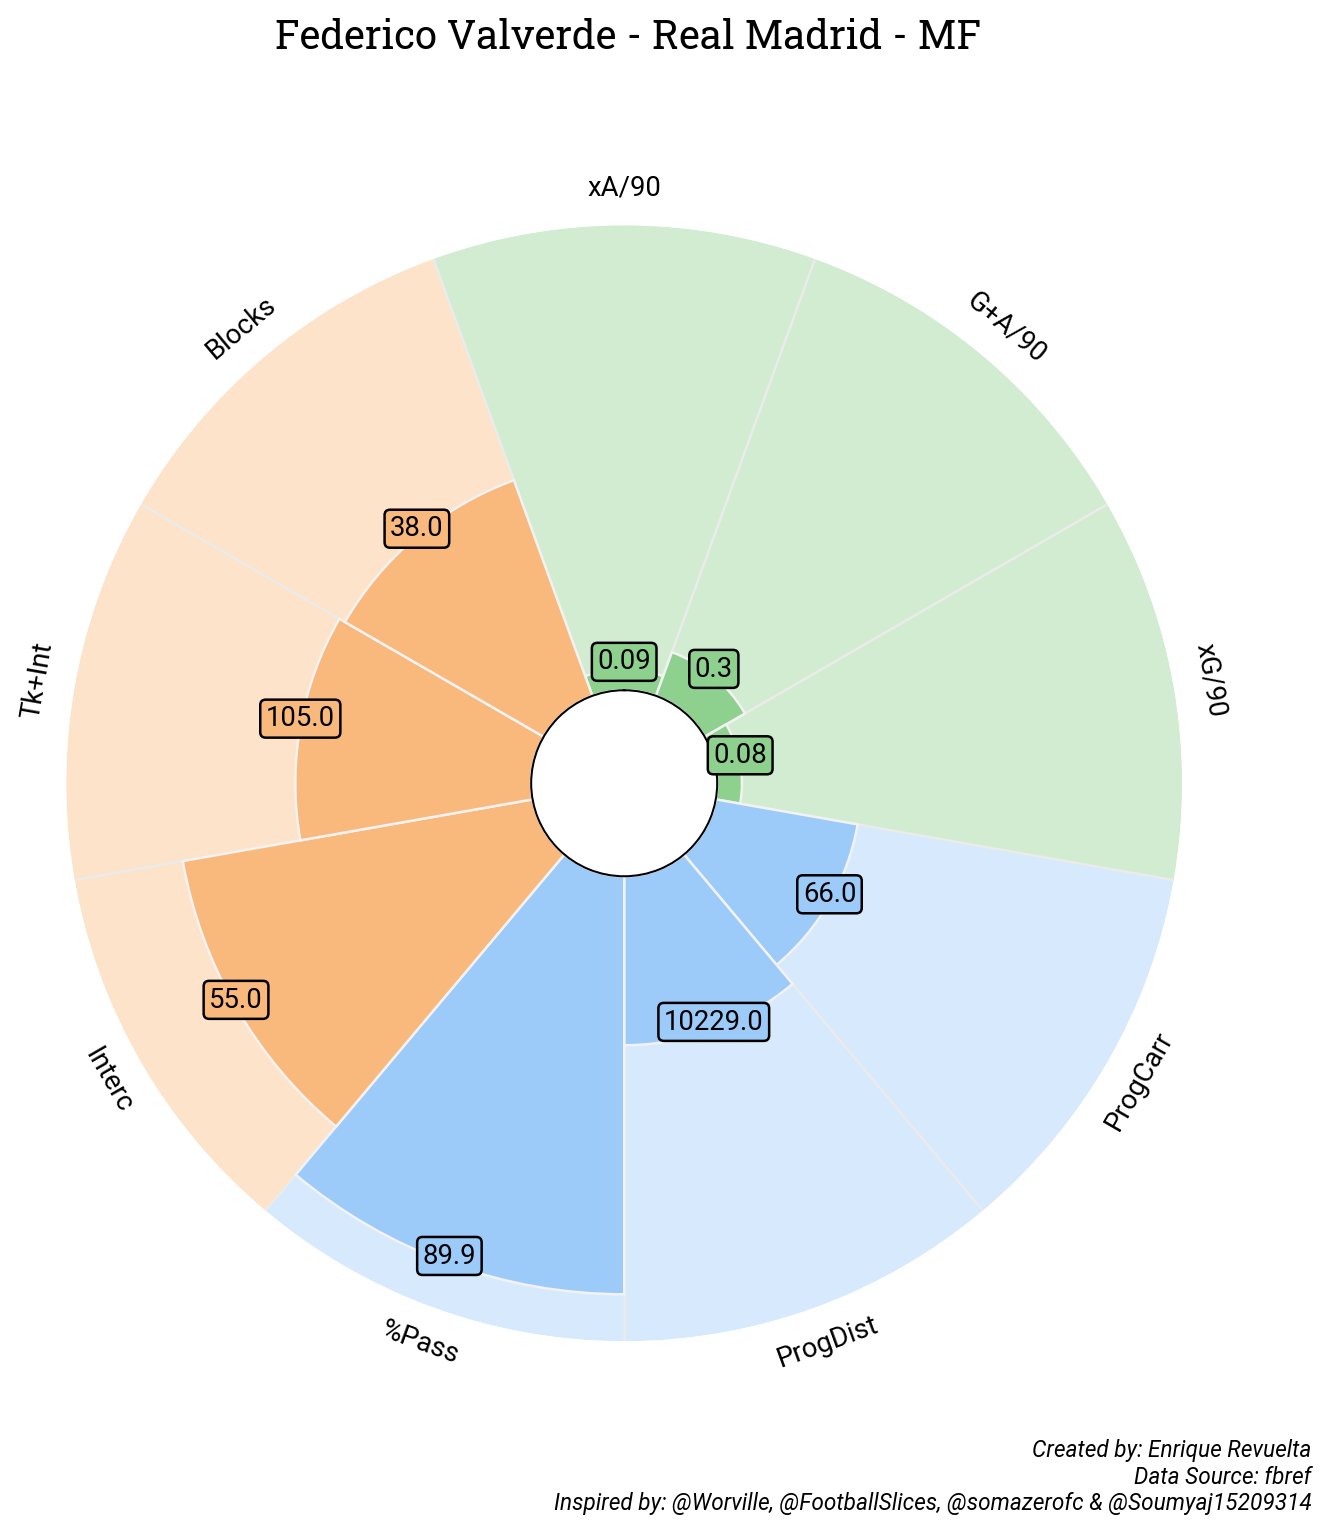

In [196]:
png = vt.pizza_chart.invoke({
    "role": row["position"],
    "stats": row.to_dict(),
    "player_name": row["full_name"],
    "team": row["club"],
})
display(Image(png))

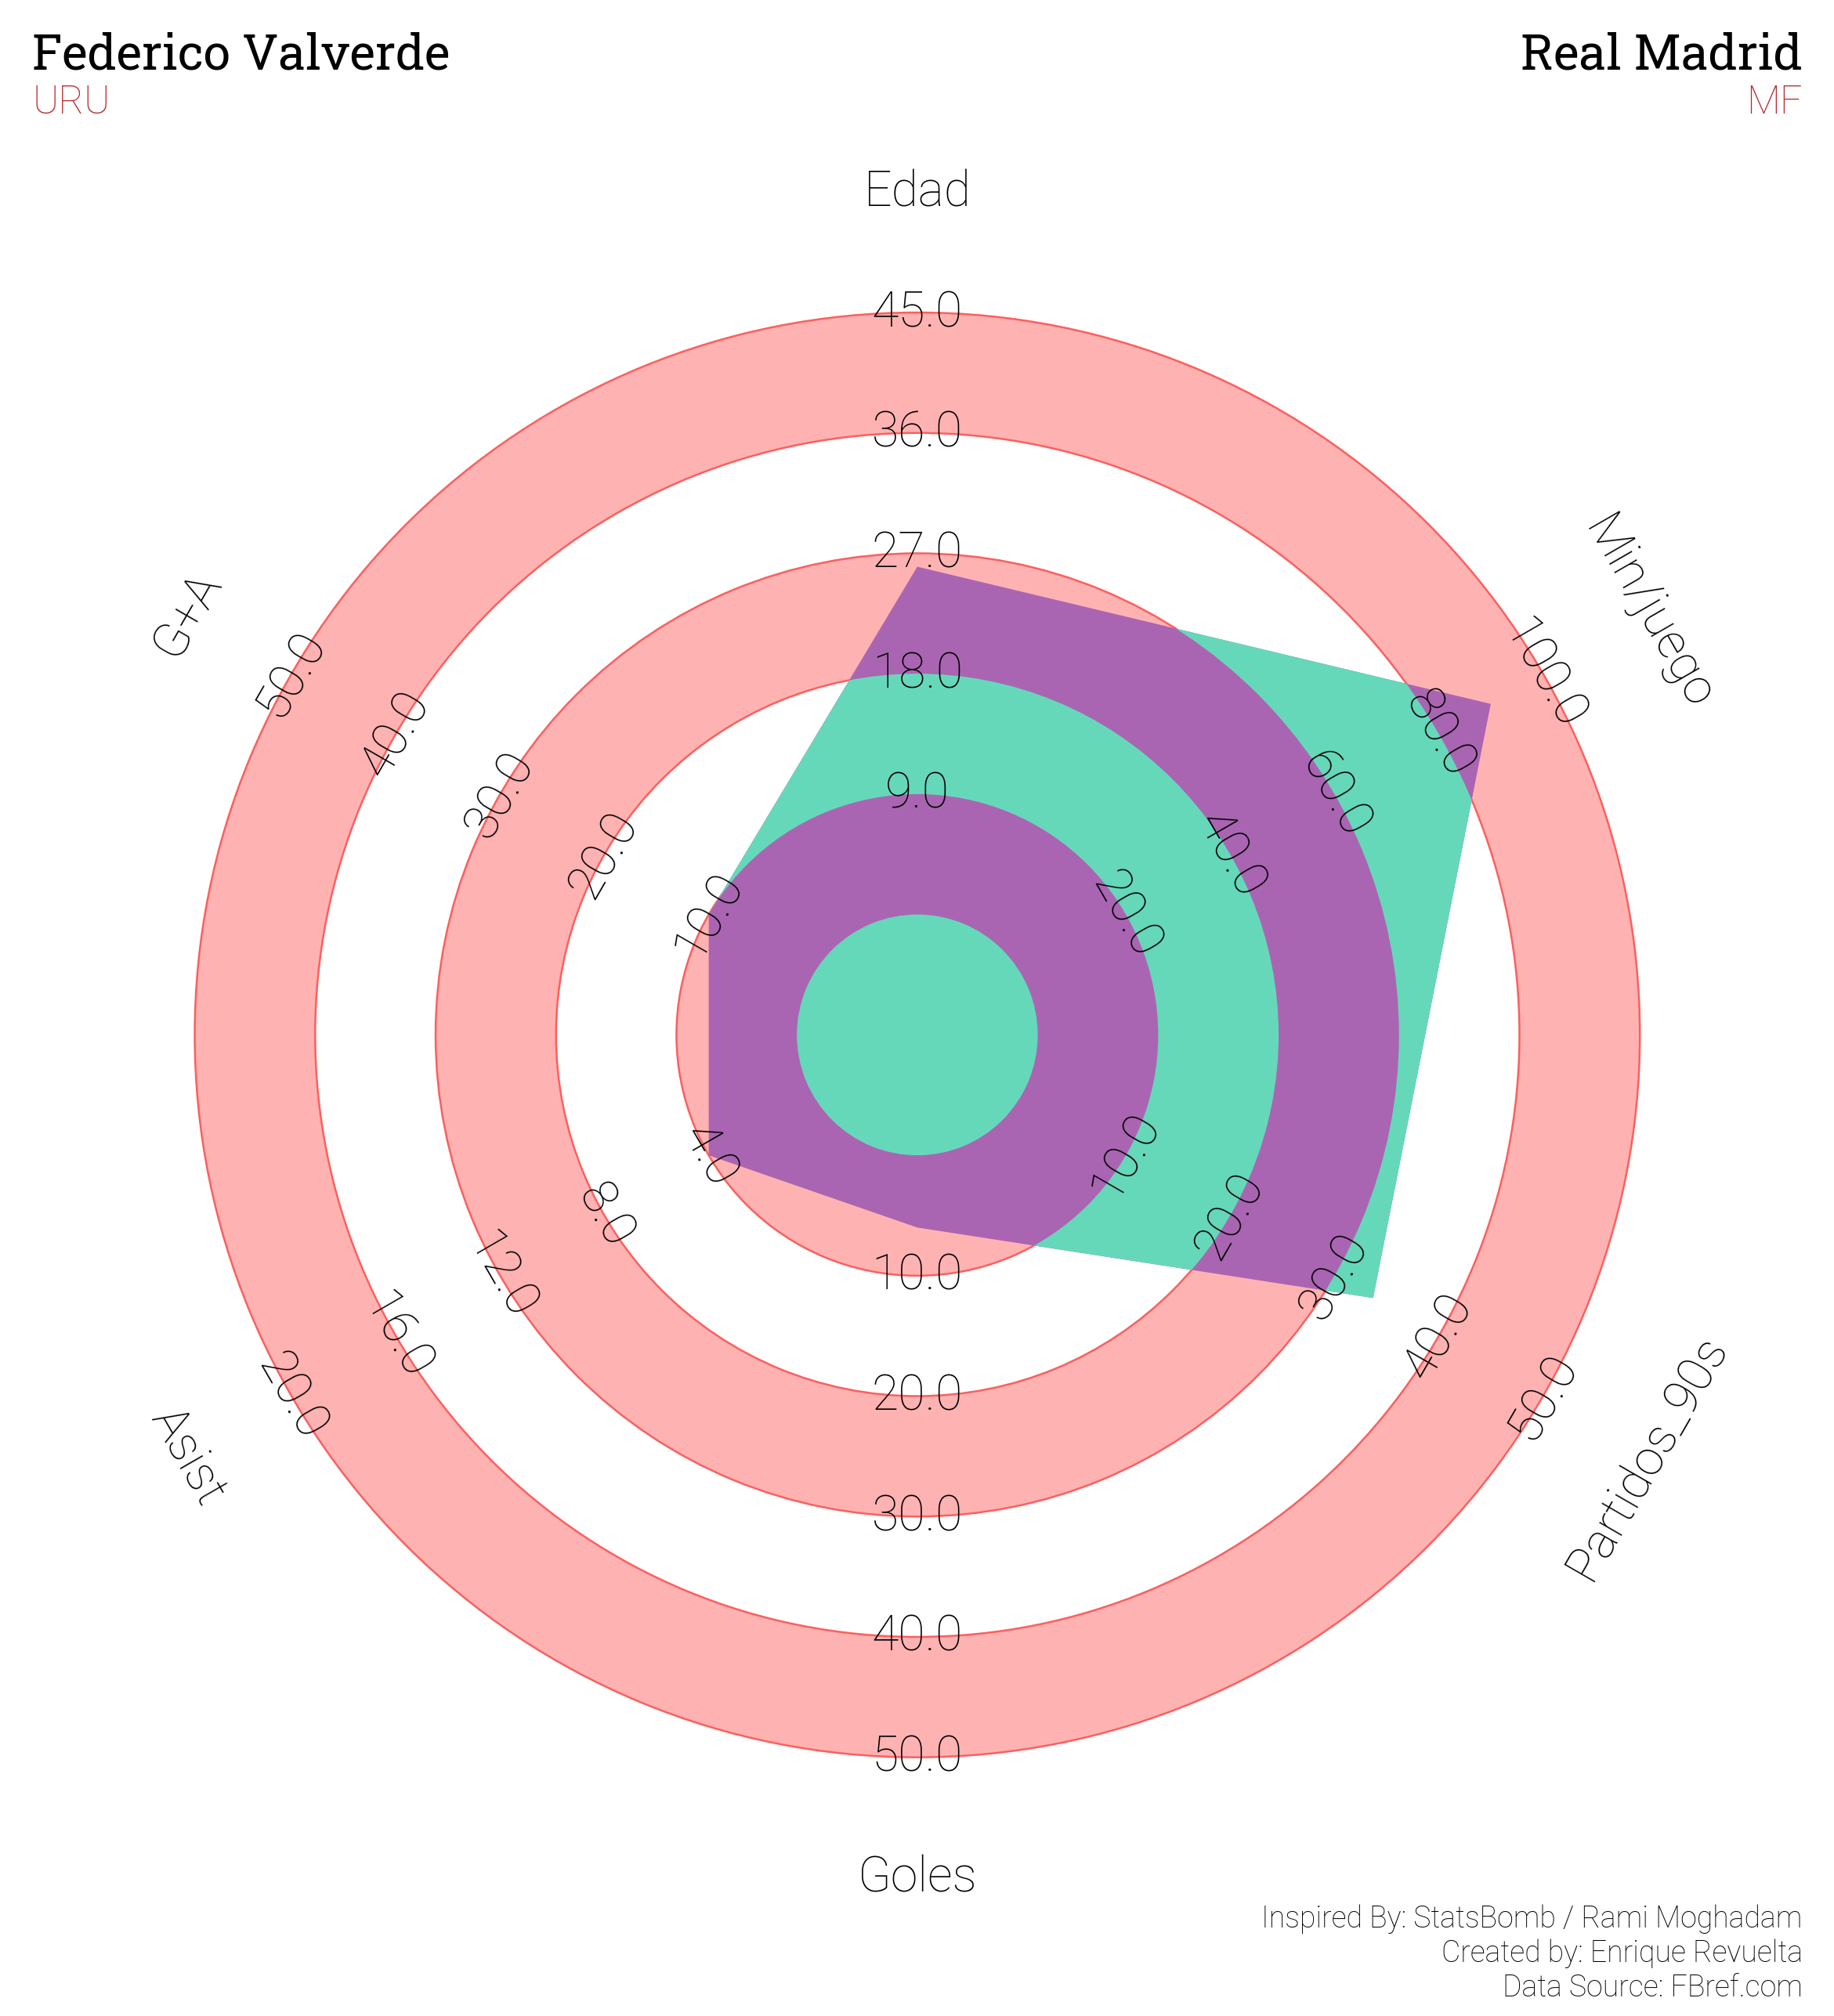

In [199]:
path = vt.radar_chart.invoke({
    "stats": row.to_dict(),
    "player_name": row["full_name"],
    "team": row["club"],
    "position": row["position"],
    "nationality": row["nationality"]
})
display(Image(path))

In [5]:
from pathlib import Path
import urllib.request as urlreq

# 1⃣  Carpeta destino dentro del repositorio
FONTS_DIR = Path("../apps/agent_service/fonts")
FONTS_DIR.mkdir(parents=True, exist_ok=True)

# 2⃣  URL de cada peso + nombre local
FONTS = {
    "serif_regular.ttf"     : "https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/SourceSerifPro-Regular.ttf",
    "serif_extra_light.ttf" : "https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/SourceSerifPro-ExtraLight.ttf",
    "rubik_regular.ttf"     : "https://raw.githubusercontent.com/google/fonts/main/ofl/rubikmonoone/RubikMonoOne-Regular.ttf",
    "robotto_thin.ttf"      : "https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Thin.ttf",
    "robotto_bold.ttf"      : "https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/RobotoSlab%5Bwght%5D.ttf",
    "RobotoSlab-Bold.ttf"   : "https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Regular.ttf",
    "RobotoSlab-Regular.ttf": "https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Italic.ttf",
    "RobotoSlab-Italic.ttf" : "https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/RobotoSlab[wght].ttf",
}

for fname, url in FONTS.items():
    try:
        dest = FONTS_DIR / fname
        if not dest.exists():                       # descarga solo si no lo tienes
            print(f"→ Descargando {fname}…")
            urlreq.urlretrieve(url, dest)
        else:
            print(f"✓ {fname} ya está en disco")
    except:
        print(f"Fallo al descargar {fname}")

print("¡Fuentes listas!")

✓ serif_regular.ttf ya está en disco
✓ serif_extra_light.ttf ya está en disco
✓ rubik_regular.ttf ya está en disco
✓ robotto_thin.ttf ya está en disco
✓ robotto_bold.ttf ya está en disco
✓ RobotoSlab-Bold.ttf ya está en disco
✓ RobotoSlab-Regular.ttf ya está en disco
✓ RobotoSlab-Italic.ttf ya está en disco
¡Fuentes listas!
